In [1]:
import numpy as np
import tensorflow as tf

import os
# np.random.seed(1337)  # for reproducibility
# tf.random.set_seed(1337)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC '] = '1'


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
base_coin_str = 'BTC'
base_coin_fullname_str = 'bitcoin'

In [3]:
from data.utils import load_data
from data.scaling import normalize

filtro_tipos_eventos_permitidos = ['listing', 'launch', 'fork']
query_str = 'title.isna()'
for filtro in filtro_tipos_eventos_permitidos:
    query_str += f' or title.str.lower().str.contains("{filtro}")'
    # df = df.query(f'event_title.isna() or event_title.str.lower().str.contains("{filtro}")')
print(query_str)

title.isna() or title.str.lower().str.contains("listing") or title.str.lower().str.contains("launch") or title.str.lower().str.contains("fork")


In [4]:
df = load_data(base_coin_str, base_coin_fullname_str, event_days_left_lookback=7, storage_folder='../data', events_query=query_str)
prices, _ = normalize(df.loc[:, 'price'].to_numpy())
variation = df.loc[:, 'price (%)'].to_numpy()
# variation = df.loc[:, 'price'].pct_change().fillna(0).to_numpy()
volume, _ = normalize(df['Volume'].to_numpy())
volume_variation = df['Volume'].pct_change().fillna(0).to_numpy()
tweet, _ = normalize(df.loc[:, 'tweet_volume'].to_numpy())
tweet_variation = df.loc[:, 'tweet_volume'].pct_change().fillna(0).to_numpy()
google_trends, _ = normalize(df.loc[:, 'trend'].to_numpy())
google_trends_variation = df.loc[:, 'trend'].pct_change().fillna(0).to_numpy()

In [5]:
STOCHk_7, _ = normalize(df['STOCHk_7'].fillna(50.0).to_numpy())
STOCHk_15, _ = normalize(df['STOCHk_15'].fillna(50.0).to_numpy())
STOCHk_30, _ = normalize(df['STOCHk_30'].fillna(50.0).to_numpy())
STOCHk_60, _ = normalize(df['STOCHk_60'].fillna(50.0).to_numpy())

RSI_7, _ = normalize(df['RSI_7'].fillna(50.0).to_numpy())
RSI_15, _ = normalize(df['RSI_15'].fillna(50.0).to_numpy())
RSI_30, _ = normalize(df['RSI_30'].fillna(50.0).to_numpy())
RSI_60, _ = normalize(df['RSI_60'].fillna(50.0).to_numpy())

STOCHRSI_7, _ = normalize(df['STOCHRSI_7'].fillna(50.0).to_numpy())
STOCHRSI_15, _ = normalize(df['STOCHRSI_15'].fillna(50.0).to_numpy())
STOCHRSI_30, _ = normalize(df['STOCHRSI_30'].fillna(50.0).to_numpy())
STOCHRSI_60, _ = normalize(df['STOCHRSI_60'].fillna(50.0).to_numpy())

In [6]:
from typing import Tuple
# look_behind: passos (dias) anteriores usados para prever o proximo.
N = 30
foward_days = 1  # quantos dias prever

def to_keras_format(features: list, target) -> Tuple[np.array, np.array]:
    n_samples = len(target) - N - (foward_days-1)
    # matriz de dimensao: [n_samples, N, n_features];
    features_set = np.empty((n_samples, N, len(features)))  # type: np.ndarray
    labels = [None]*n_samples
    for i in range(n_samples):
        for j in range(N):
            for ft_idx in range(len(features)):
                feature = features[ft_idx]
                features_set[i, j, ft_idx] = feature[i+j]

        labels[i] = target[N+i-1: N+i+foward_days]
    labels = np.array(labels)

    return features_set, labels

In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense

def build_model(train_X, train_y) -> Model:
    inputs = Input(shape=train_X.shape[1:])
    lstm = LSTM(units=750, return_sequences=False, input_shape=train_X.shape[1:])(inputs)
    lstm = Dropout(0.1)(lstm)
    x = Dense(units=175, activation='linear')(lstm)
    x = Dropout(0.1)(x)
    x = Dense(units=75, activation='linear')(x)
    x = Dropout(0.1)(x)
    x = Dense(units=foward_days)(x)
    return Model(inputs=inputs, outputs=x)

In [8]:
from matplotlib import pyplot as plt
# vizualizando estatisticas do modelo em si e seu treino
def plot_train_history(modelo: Model, plot_above_or_below_zero_accuracy: bool, plotValidation = True, figsize=(25,10)):
    plt.rcParams['figure.figsize'] = figsize
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    ax1.plot(modelo.history.history['loss'])
    if plotValidation: ax1.plot(modelo.history.history['val_loss'])
    ax1.title.set_text('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')

    ax2.plot(modelo.history.history['mean_squared_error'])
    if plotValidation: ax2.plot(modelo.history.history['val_mean_squared_error'])
    ax2.title.set_text('model meanSquaredError')
    ax2.set_ylabel('mse')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

    ax3.plot(modelo.history.history['movement_accuracy'])
    if plotValidation: ax3.plot(modelo.history.history['val_movement_accuracy'])
    ax3.title.set_text('model movement direction accuracy')
    ax3.set_ylabel('accuracy')
    ax3.set_xlabel('epoch')
    ax3.legend(['train', 'test'], loc='upper left')

    # plote esse apenas se seu dado target for de variação (não faz sentido para dado bruto)
    if plot_above_or_below_zero_accuracy:
        ax4.plot(modelo.history.history['above_or_below_zero_accuracy'])
        if plotValidation: ax4.plot(modelo.history.history['val_above_or_below_zero_accuracy'])
        ax4.title.set_text('price up or down accuracy *')
        ax4.set_ylabel('accuracy')
        ax4.set_xlabel('epoch')
        ax4.legend(['train', 'test'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [12]:
# tf.keras.backend.clear_session() #limpa modelos e dados anteriores, para evitar vazamento de memoria
from metrics.custom import above_or_below_zero_accuracy, movement_accuracy
from metrics.custom import mean_squared_error, cosine_similarity as custom_cosine_similarity, mean_absolute_percentage_error
from metrics.custom import RootMeanSquaredError

from sklearn.model_selection import KFold, RepeatedKFold
from shutil import rmtree

def get_model_name(k, n_repeat = None):
    if n_repeat:
        return 'model_'+str(k)+'_'+str(n_repeat)+'.h5'
    return 'model_'+str(k)+'.h5'

def build_and_run_and_show(features, target, loss_function, shuffle_mask=None, epochs=400, batch_size=128) -> Model:
    save_dir = './tmp_altcoins/saved_models/'
    if os.path.exists(save_dir):
        rmtree(save_dir)

    features_set, labels = to_keras_format(features, target)

    if shuffle_mask is None:
        shuffle_mask = np.arange(len(features_set))
        np.random.shuffle(shuffle_mask)

    unshuffle_mask = np.zeros(len(shuffle_mask), dtype=int)
    for i in range(len(shuffle_mask)):
        unshuffle_mask[shuffle_mask[i]] = i

    features_set, labels = features_set[shuffle_mask], labels[shuffle_mask]

    
    TEST_MSE = []
    TEST_MOV_ACCURACY = []
    TEST_UPDOWN_ACCURACY = []
    # kf = KFold(n_splits = 5)
    n_repeats = 2
    kf = RepeatedKFold(n_splits = 5, n_repeats = n_repeats, random_state=1337) # random_state fixo para manter reproducibilidade entre chamadas dessa função

    fold_num = 1
    repeat_num = 1
    for train_index, test_index  in kf.split(features_set, labels):
        tf.keras.backend.clear_session()

        train_X, train_y = features_set[train_index], labels[train_index]
        test_X, test_y = features_set[test_index], labels[test_index]

        model = build_model(train_X, train_y)
        opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
        model.compile(optimizer=opt, loss=loss_function, metrics=[mean_squared_error, movement_accuracy, above_or_below_zero_accuracy])# 'cosine_similarity', 'mean_squared_error'

        # CREATE CALLBACKS
        best_mse_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mse/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_mean_squared_error:.5f}', 
                                monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
        best_movAcc_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mov_accuracy/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_movement_accuracy:.5f}', 
                                monitor='val_movement_accuracy', verbose=0, save_best_only=True, mode='max')
        best_above_below_zero_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'above_or_below_zero_accuracy/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_movement_accuracy:.5f}', 
                                monitor='val_above_or_below_zero_accuracy', verbose=0, save_best_only=True, mode='max')
        checkpoints = [best_mse_checkpoint, best_movAcc_checkpoint, best_above_below_zero_checkpoint]

        print(f'treinando fold {fold_num}, repetição {repeat_num} (400 epochs dá 2min +-)')
        model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=epochs, batch_size=batch_size, callbacks=checkpoints, verbose=0)
        

        # PLOT HISTORY
        plot_train_history(model, plot_above_or_below_zero_accuracy=True, figsize=(25,8))

        # LOAD BEST MODEL (for specific metric) to evaluate the performance of the model
        model.load_weights(save_dir+"mse/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_MSE.append(results['mean_squared_error'])
        
        model.load_weights(save_dir+"mov_accuracy/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_MOV_ACCURACY.append(results['movement_accuracy'])

        model.load_weights(save_dir+"above_or_below_zero_accuracy/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_UPDOWN_ACCURACY.append(results['above_or_below_zero_accuracy'])

        if repeat_num % n_repeats == 0:
            fold_num +=1
            repeat_num = 1
        else:    
            repeat_num += 1        

        rmtree(save_dir)
        tf.keras.backend.clear_session()

    print('\nResults:\n')
    print(f'MeanSquaredError: {TEST_MSE}')
    print(f'MovementDiretionAccuracy: {TEST_MOV_ACCURACY}')
    print(f'AboveOrBellowAccuracy: {TEST_UPDOWN_ACCURACY}\n')
    print(f'MeanSquaredError mean: {np.mean(TEST_MSE)}')
    print(f'MovementDiretionAccuracy mean: {np.mean(TEST_MOV_ACCURACY)}')
    print(f'AboveOrBellowAccuracy mean: {np.mean(TEST_UPDOWN_ACCURACY)}\n')
    print(f'MeanSquaredError std: {np.std(TEST_MSE)}')
    print(f'MovementDiretionAccuracy std: {np.std(TEST_MOV_ACCURACY)}')
    print(f'AboveOrBellowAccuracy std: {np.std(TEST_UPDOWN_ACCURACY)}')

    return

# Testando com features basicas depois com indicadores técnicos

In [17]:
features_set, _ = to_keras_format([variation], variation)
shuffle_mask = np.arange(len(features_set))
np.random.shuffle(shuffle_mask)

treinando fold 1, repetição 1 (400 epochs dá 2min +-)


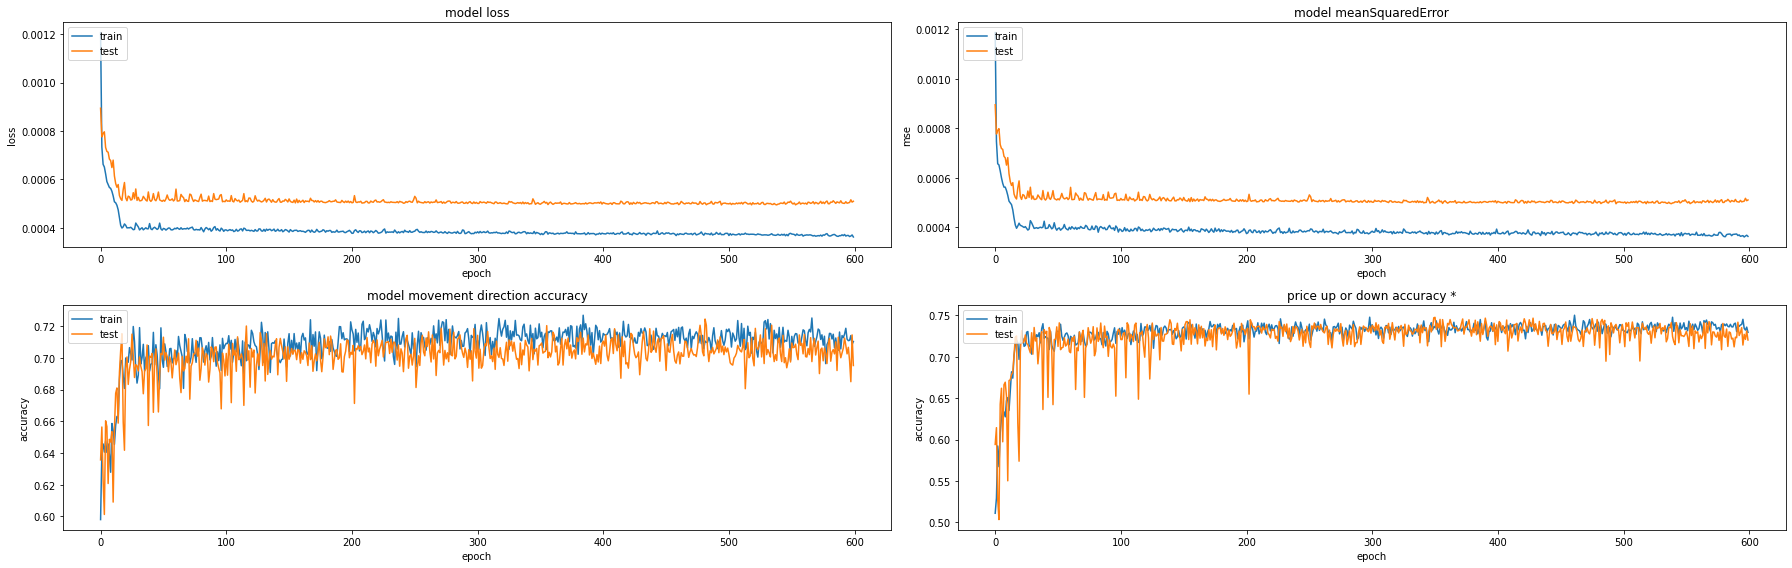

498/498 [==============================] - 3s 5ms/step - loss: 4.9737e-04 - mean_squared_error: 4.9737e-04 - movement_accuracy: 0.7088 - above_or_below_zero_accuracy: 0.7490
treinando fold 1, repetição 2 (400 epochs dá 2min +-)


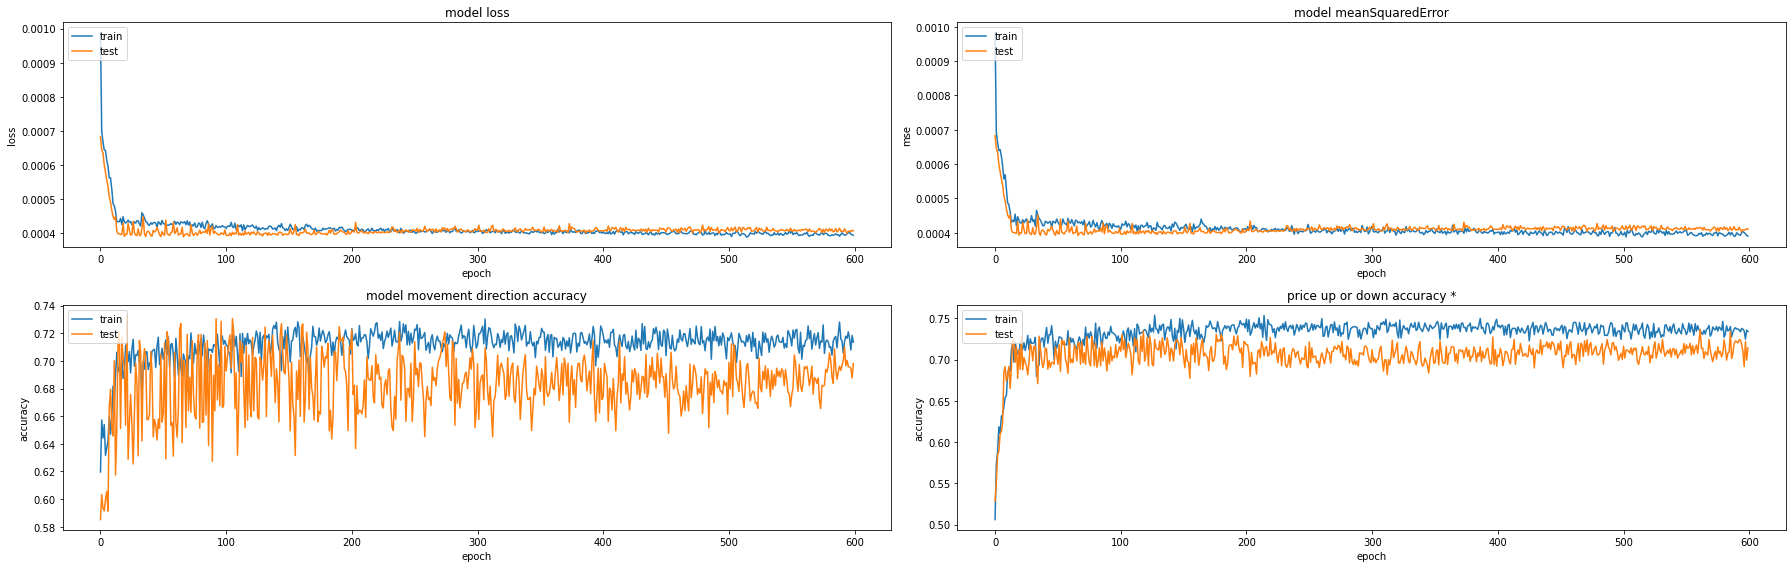

498/498 [==============================] - 3s 6ms/step - loss: 4.1245e-04 - mean_squared_error: 4.1245e-04 - movement_accuracy: 0.6948 - above_or_below_zero_accuracy: 0.7349
treinando fold 2, repetição 1 (400 epochs dá 2min +-)


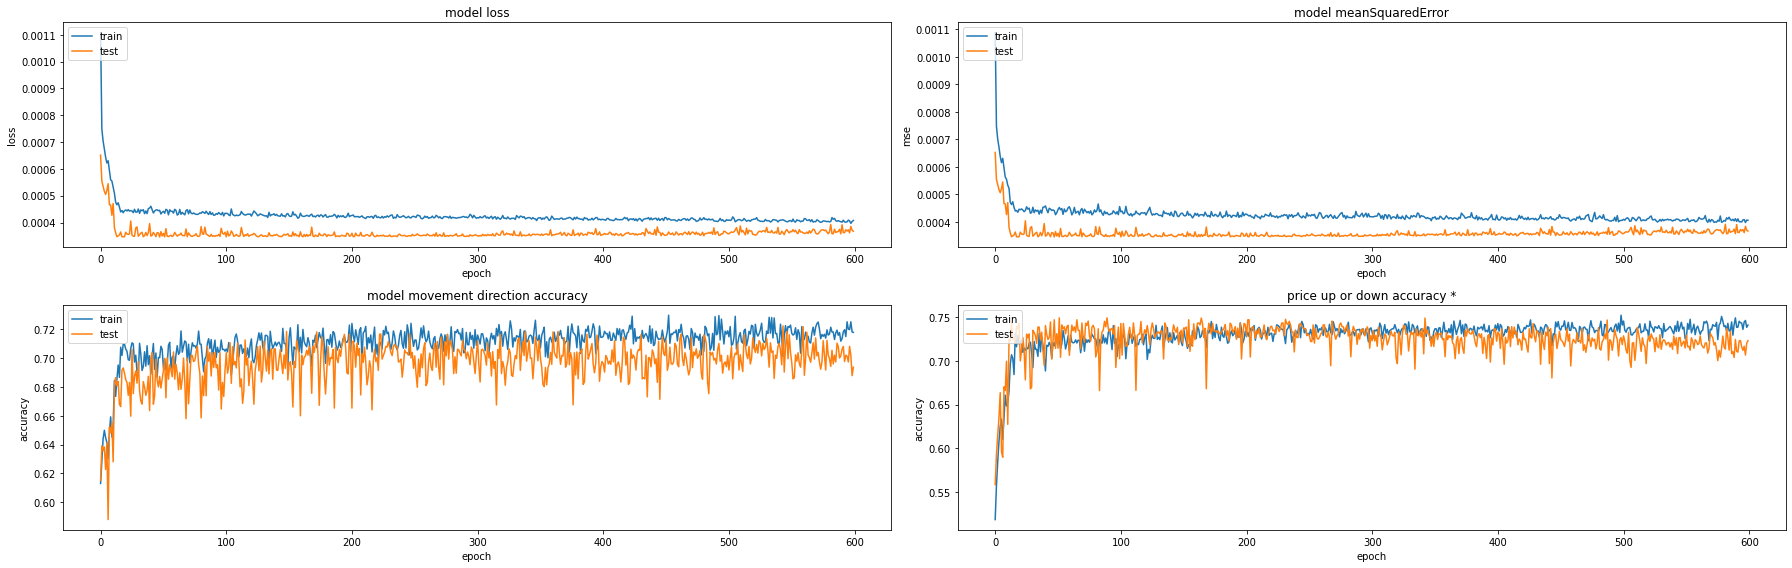

497/497 [==============================] - 3s 6ms/step - loss: 3.4669e-04 - mean_squared_error: 3.4669e-04 - movement_accuracy: 0.6982 - above_or_below_zero_accuracy: 0.7485
treinando fold 2, repetição 2 (400 epochs dá 2min +-)


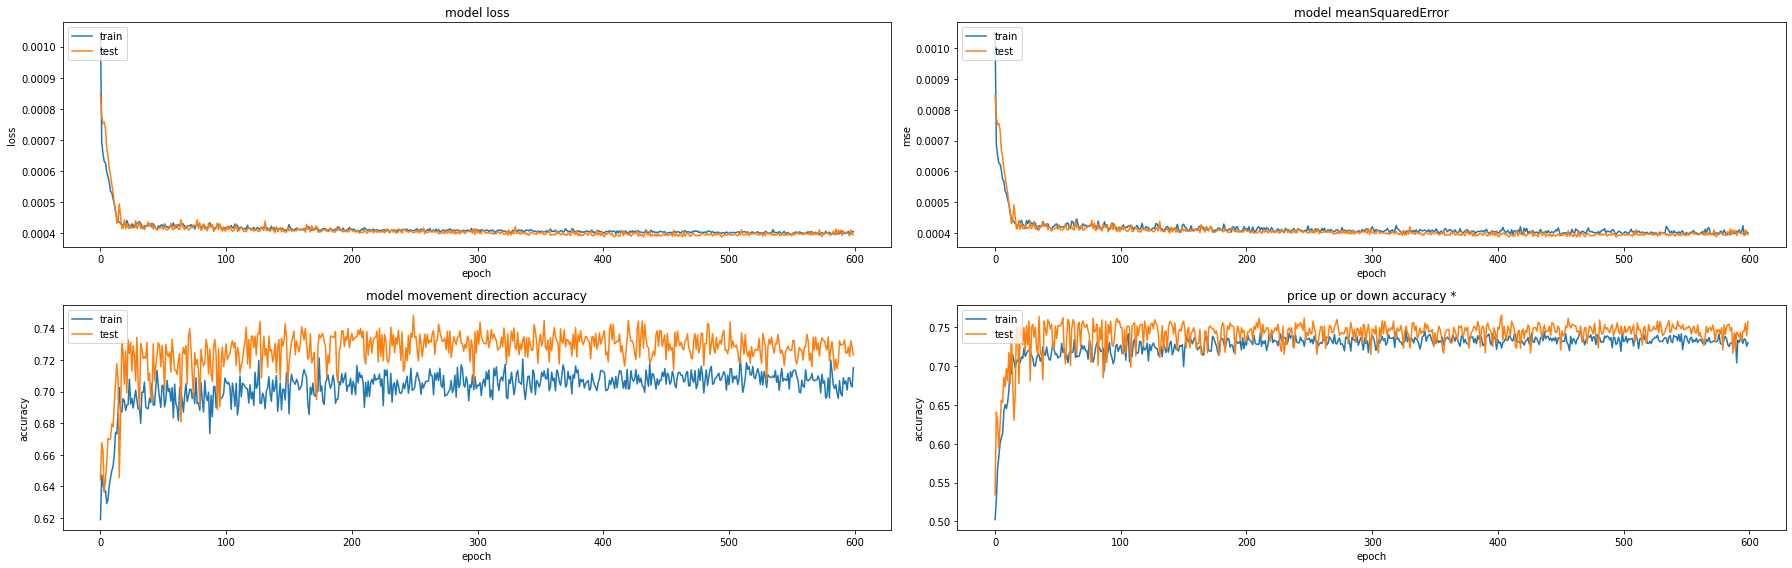

497/497 [==============================] - 3s 6ms/step - loss: 3.9573e-04 - mean_squared_error: 3.9573e-04 - movement_accuracy: 0.7264 - above_or_below_zero_accuracy: 0.7646
treinando fold 3, repetição 1 (400 epochs dá 2min +-)


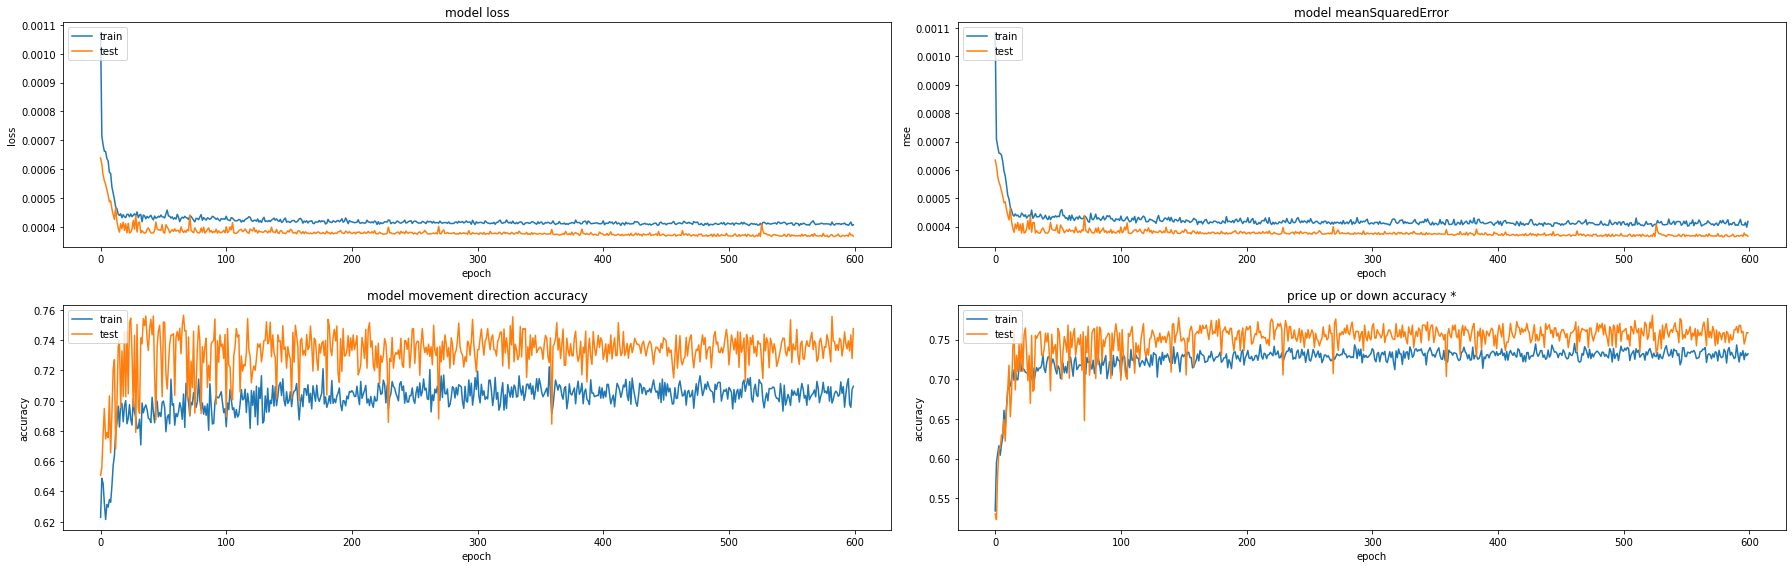

497/497 [==============================] - 3s 6ms/step - loss: 3.6711e-04 - mean_squared_error: 3.6711e-04 - movement_accuracy: 0.7384 - above_or_below_zero_accuracy: 0.7807
treinando fold 3, repetição 2 (400 epochs dá 2min +-)


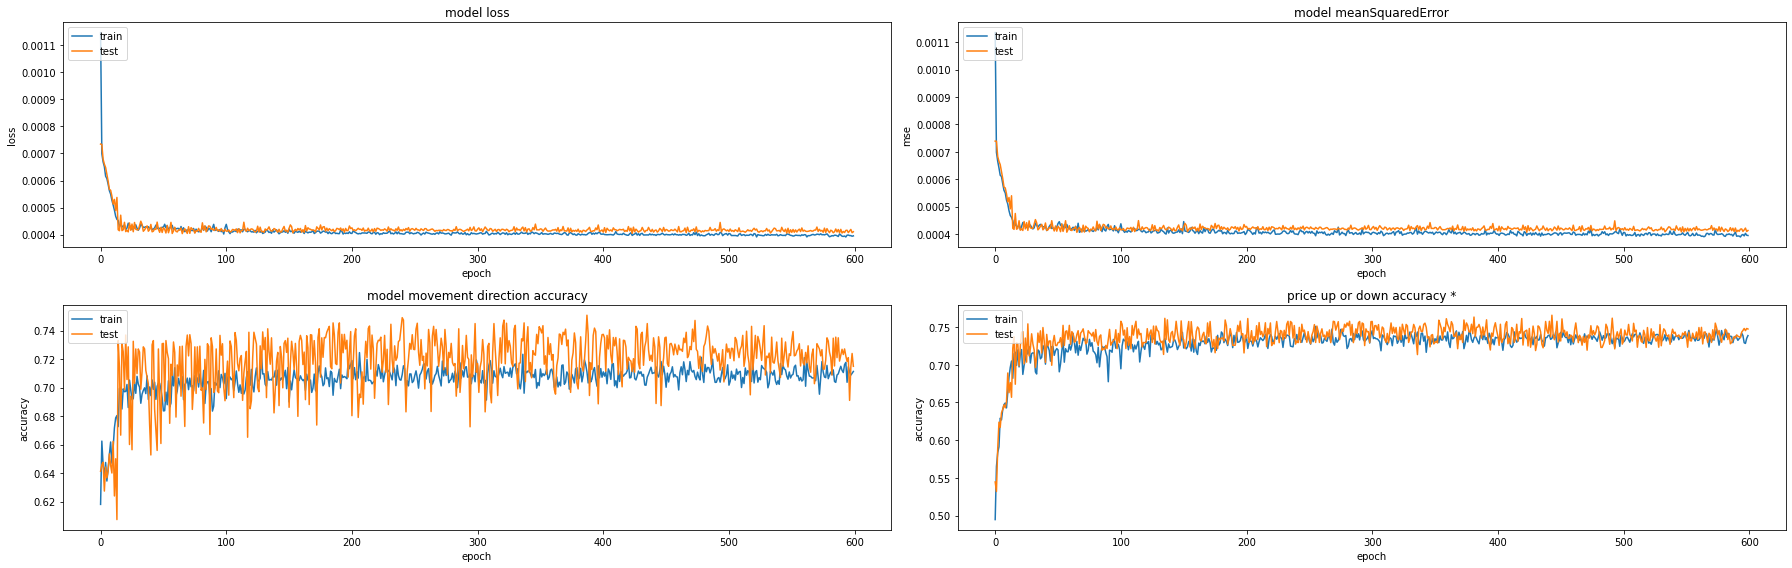

498/498 [==============================] - 3s 6ms/step - loss: 4.0933e-04 - mean_squared_error: 4.0933e-04 - movement_accuracy: 0.7189 - above_or_below_zero_accuracy: 0.7651
treinando fold 4, repetição 1 (400 epochs dá 2min +-)


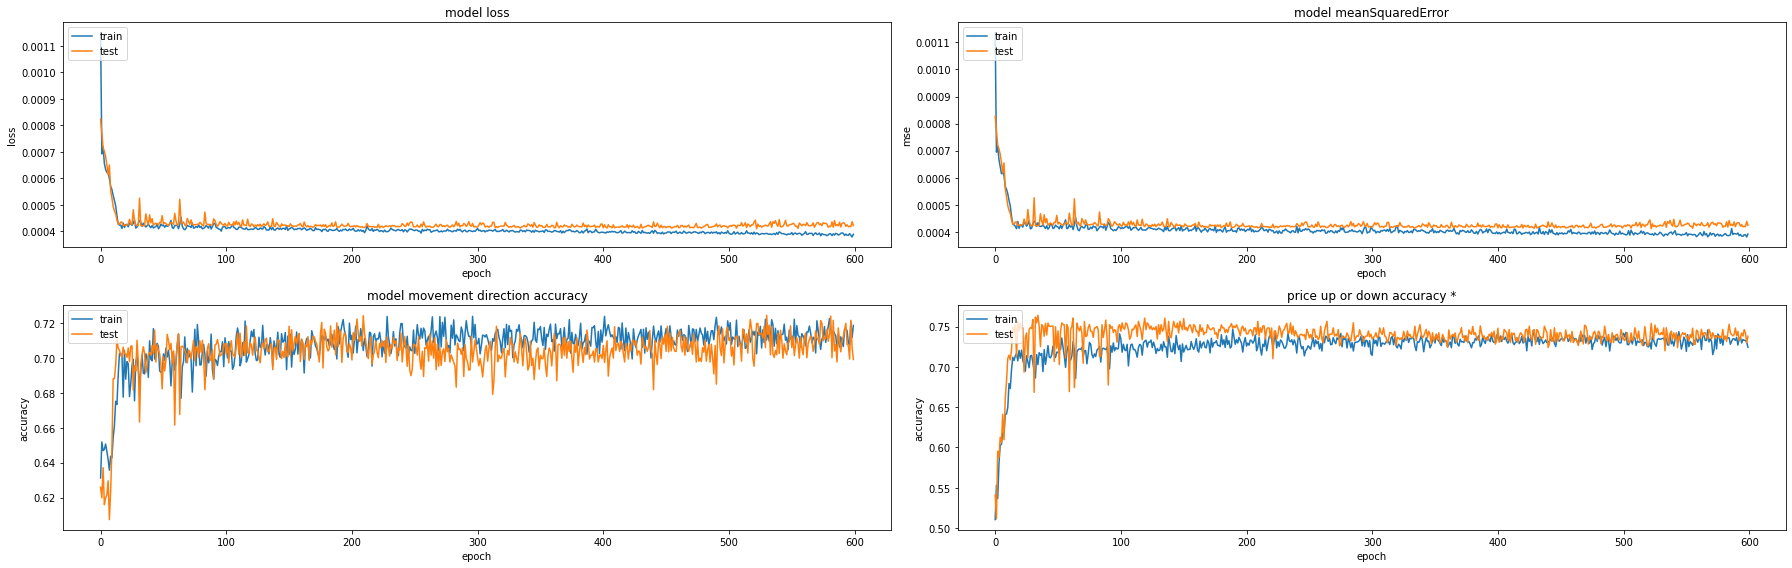

498/498 [==============================] - 3s 6ms/step - loss: 4.2187e-04 - mean_squared_error: 4.2187e-04 - movement_accuracy: 0.7068 - above_or_below_zero_accuracy: 0.7631
treinando fold 4, repetição 2 (400 epochs dá 2min +-)


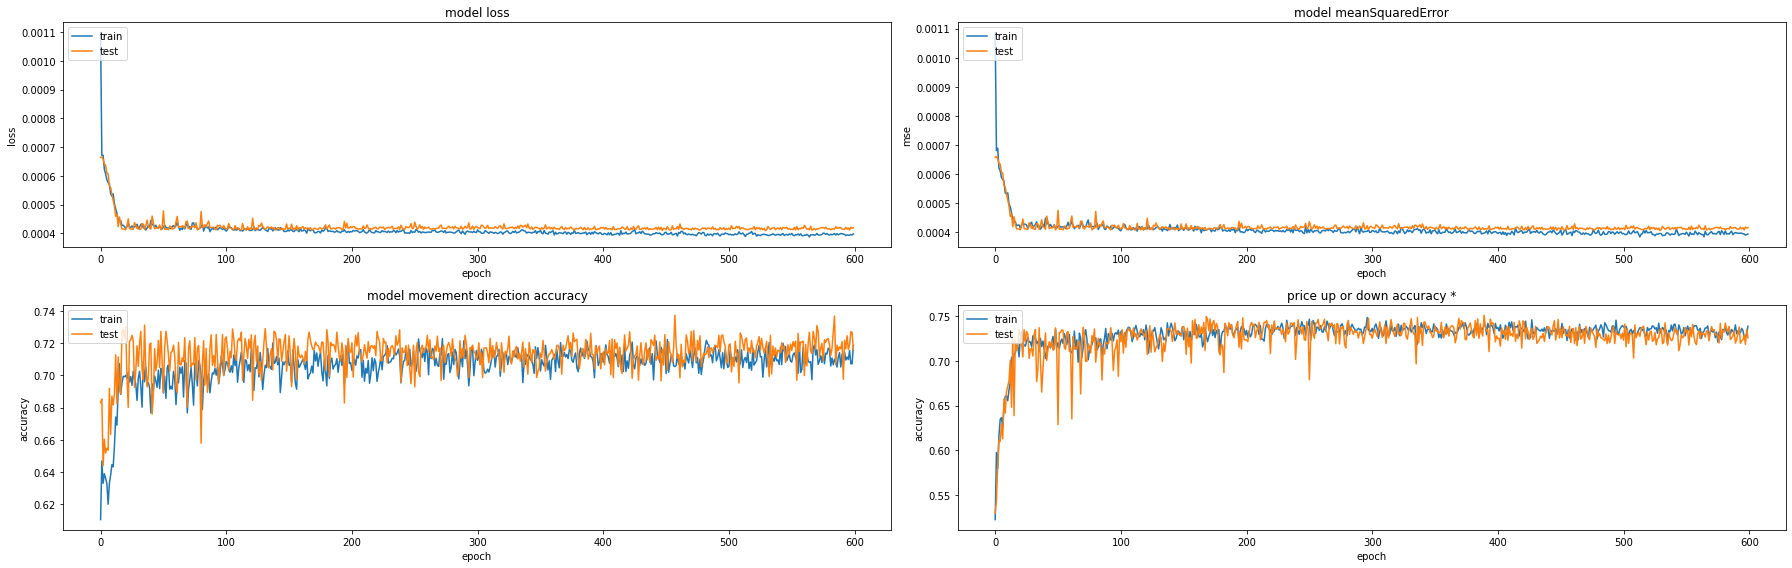

497/497 [==============================] - 3s 6ms/step - loss: 4.1233e-04 - mean_squared_error: 4.1233e-04 - movement_accuracy: 0.7123 - above_or_below_zero_accuracy: 0.7505
treinando fold 5, repetição 1 (400 epochs dá 2min +-)


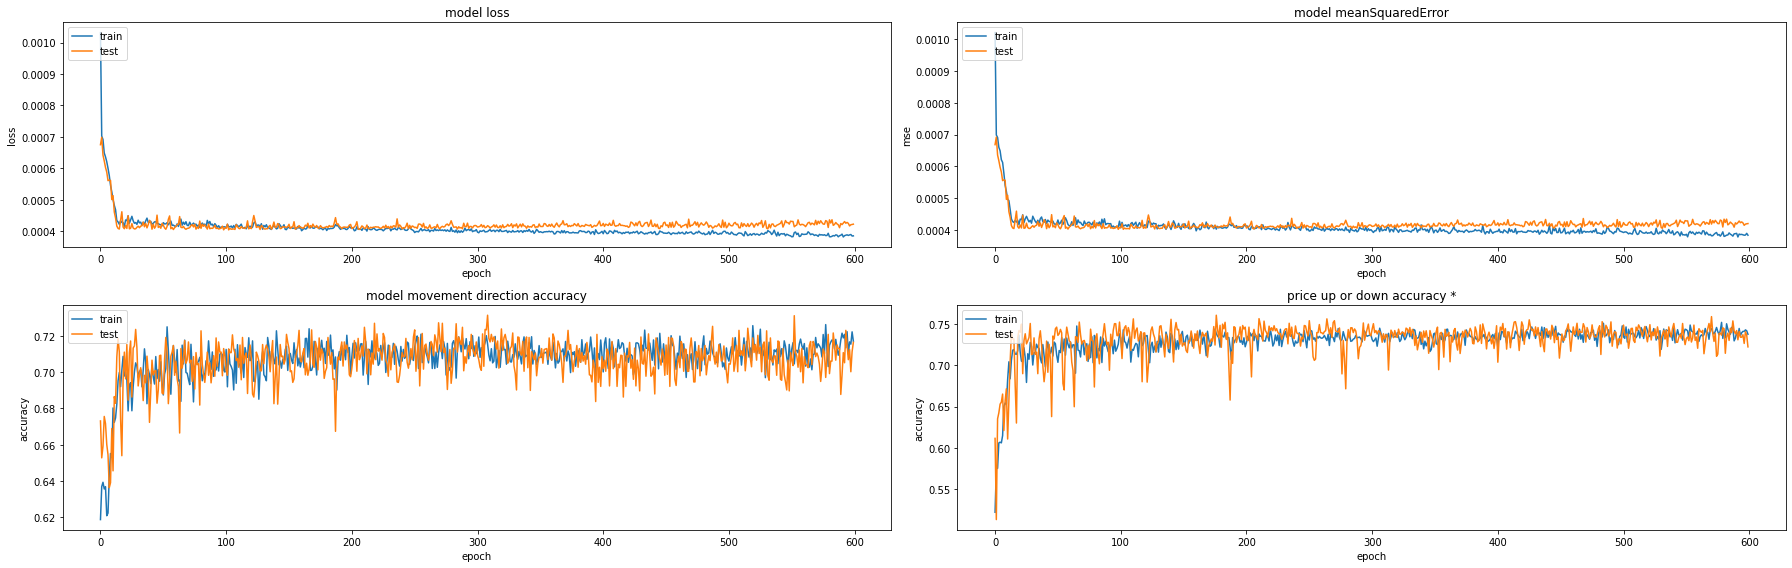

497/497 [==============================] - 3s 6ms/step - loss: 4.1264e-04 - mean_squared_error: 4.1264e-04 - movement_accuracy: 0.7123 - above_or_below_zero_accuracy: 0.7606
treinando fold 5, repetição 2 (400 epochs dá 2min +-)


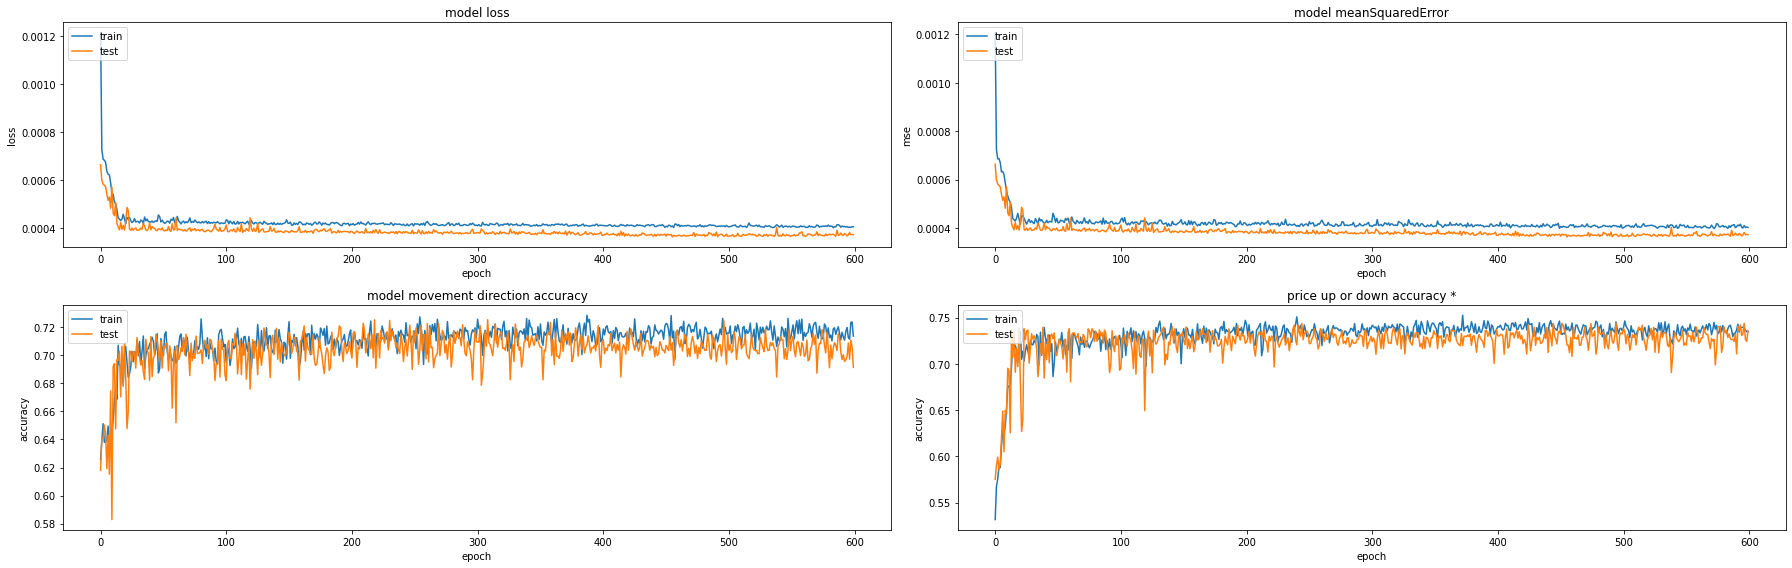

497/497 [==============================] - 3s 6ms/step - loss: 3.8180e-04 - mean_squared_error: 3.8180e-04 - movement_accuracy: 0.6982 - above_or_below_zero_accuracy: 0.7445

Results:

MeanSquaredError: [0.0004943209351040423, 0.0003895767731592059, 0.0003460567386355251, 0.0003871862427331507, 0.00036457309033721685, 0.0004036978061776608, 0.00041063790558837354, 0.00040919147431850433, 0.00040422522579319775, 0.0003626118414103985]
MovementDiretionAccuracy: [0.7248995900154114, 0.7329317331314087, 0.7203219532966614, 0.7484909296035767, 0.7545271515846252, 0.7510040402412415, 0.7248995900154114, 0.7364184856414795, 0.7303823232650757, 0.7243461012840271]
AboveOrBellowAccuracy: [0.7489959597587585, 0.7349397540092468, 0.7484909296035767, 0.7645875215530396, 0.7806841135025024, 0.7650602459907532, 0.763052225112915, 0.7505030035972595, 0.7605633735656738, 0.7444667816162109]

MeanSquaredError mean: 0.00039720780332572756
MovementDiretionAccuracy mean: 0.7348221898078918
AboveOrBellowAc

NameError: name 'alternative_coin_fullname_str' is not defined

In [10]:
features = [variation]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

In [ ]:
features = [variation, volume_variation]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

# Agora vamo ver como a adição de variação de volume vai afetar

## Ethereum

In [ ]:
base_coin_str = 'ETH'
base_coin_fullname_str = 'ethereum'

df = load_data(base_coin_str, base_coin_fullname_str, event_days_left_lookback=7, storage_folder='../data', events_query=query_str)
variation = df.loc[:, 'price (%)'].to_numpy()
volume_variation = df['Volume'].pct_change().fillna(0).to_numpy()

In [ ]:
features = [variation,]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

In [ ]:
features = [variation, volume_variation]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

## Tron

In [ ]:
base_coin_str = 'TRX'
base_coin_fullname_str = 'tron'

df = load_data(base_coin_str, base_coin_fullname_str, event_days_left_lookback=7, storage_folder='../data', events_query=query_str)
variation = df.loc[:, 'price (%)'].to_numpy()
volume_variation = df['Volume'].pct_change().fillna(0).to_numpy()

In [ ]:
features = [variation,]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

In [ ]:
features = [variation, volume_variation]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

## EOS

In [ ]:
base_coin_str = 'EOS'
base_coin_fullname_str = 'EOS'

df = load_data(base_coin_str, base_coin_fullname_str, event_days_left_lookback=7, storage_folder='../data', events_query=query_str)
variation = df.loc[:, 'price (%)'].to_numpy()
volume_variation = df['Volume'].pct_change().fillna(0).to_numpy()

In [ ]:
features = [variation,]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')

In [ ]:
features = [variation, volume_variation]
target = variation

build_and_run_and_show(features, target, mean_squared_error, shuffle_mask = shuffle_mask, epochs = 600)  # nao teve overfitting até o epoch 400, entao bora forçar mais uns pra ver se tira mais ganho
print(f'Esse é o score do {base_coin_fullname_str} num modelo treinado por ele mesmo (mesma moeda, mas trechos de dados diferentes)\n foi usada validação cruzada (K-Fold)')